In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
sns.set_palette(sns.color_palette('Set2')[::2])
sns.set_context('paper', font_scale=1.5)

heatmap_cmap = 'GnBu'

import scipy
from scipy.stats import ttest_rel, beta, ttest_ind
from sklearn.cluster import KMeans
import numpy as np
import os
import yaml
import shutil
from collections import OrderedDict

from utils import quick_load_experiments_tsv, get_significance_by_column, add_probing_location_better_column
from common import lang2code, code2lang, lang2family, family2langs

figure_dir = "fig/tokenization"
os.makedirs("fig", exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

np.random.seed(2)

%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load data

In [2]:
exps = pd.read_table("../dataframes/all_char_experiments.tsv", sep="\t", quoting=3)
exps['tag'] = exps['task'].apply(lambda t: t.split("_")[0])
exps['pos'] = exps['task'].apply(lambda t: t.split("_")[1])
exps['full_task'] = exps['language'] + ' ' + exps['task']
exps['family'] = exps['language'].apply(lambda l: lang2family[l])
exps = add_probing_location_better_column(exps)
exps.head()

,model,language,task,perturbation,probing_location,dev_acc,test_acc,tag,pos,full_task,family,probing_location_better
0,mBERT,Afrikaans,number_noun,NaN,first,88.05,85.40,number,noun,Afrikaans number_noun,Germanic,False
1,mBERT,Afrikaans,number_noun,NaN,last,97.20,95.30,number,noun,Afrikaans number_noun,Germanic,True
2,mBERT,Afrikaans,number_noun,mBERT-char,first,66.45,61.30,number,noun,Afrikaans number_noun,Germanic,False
3,mBERT,Afrikaans,number_noun,mBERT-char,last,92.30,90.65,number,noun,Afrikaans number_noun,Germanic,True
4,mBERT,Afrikaans,number_noun,mBERT-rand-char,first,63.50,48.30,number,noun,Afrikaans number_noun,Germanic,False


## Load fertility and majority baseline

In [3]:
fertility = pd.read_table("../dataframes/task_fertility.tsv")
fertility.shape

(319, 14)

In [4]:
old_len = len(exps)

exps = exps.merge(fertility, on=['language', 'task'], how='inner')

if old_len != len(exps):
    raise ValueError(f"Merging with fertility dataframe changed the number of rows: {old_len} --> {len(exps)}")

# Perturbations

In [5]:
data_perturbations = ['TARG', 'L$_2$', 'R$_2$', 'B$_2$', 'permute']
model_perturbations = [
    'mBERT-char',
    'mBERT-rand-subw', 
    'mBERT-rand-char',
]
baseline_models = ['chLSTM', 'chLSTM-rand', 'swLSTM', 'fastText']

# Model perturbations

In [6]:
models = ['mBERT'] + model_perturbations #+ baseline_models

baselines = exps[
    ((exps.model.isin(baseline_models)) & (exps.perturbation.isnull())) |
    ((exps.model=='mBERT') & (exps.perturbation.isnull())) |
    ((exps.model=='mBERT') & (exps.perturbation.isin(model_perturbations)))
]
baselines = baselines[baselines['probing_location_better']==True].copy()
baselines

,model,language,task,perturbation,probing_location,dev_acc,test_acc,tag,pos,full_task,...,majority_baseline,sentence_char_len,sentence_char_per_subword,sentence_fertility,sentence_subword_len,sentence_word_len,target_char_len,target_char_per_subword,target_fertility,target_subw_entropy
1,mBERT,Afrikaans,number_noun,NaN,last,97.20,95.30,number,noun,Afrikaans number_noun,...,50.0,127.413750,3.001271,1.731115,42.552500,24.793750,10.723333,3.508751,3.307917,8.491142
3,mBERT,Afrikaans,number_noun,mBERT-char,last,92.30,90.65,number,noun,Afrikaans number_noun,...,50.0,127.413750,3.001271,1.731115,42.552500,24.793750,10.723333,3.508751,3.307917,8.491142
5,mBERT,Afrikaans,number_noun,mBERT-rand-char,last,88.00,85.15,number,noun,Afrikaans number_noun,...,50.0,127.413750,3.001271,1.731115,42.552500,24.793750,10.723333,3.508751,3.307917,8.491142
7,mBERT,Afrikaans,number_noun,mBERT-rand-subw,last,81.10,83.80,number,noun,Afrikaans number_noun,...,50.0,127.413750,3.001271,1.731115,42.552500,24.793750,10.723333,3.508751,3.307917,8.491142
9,mBERT,Albanian,case_noun,NaN,last,70.75,69.35,case,noun,Albanian case_noun,...,22.0,92.291667,2.543321,1.816678,36.396667,20.165833,8.132917,2.928065,2.995000,9.108299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543,mBERT,Urdu,gender_noun,mBERT-rand-subw,last,70.35,72.90,gender,noun,Urdu gender_noun,...,69.5,90.946250,2.057679,1.745311,44.379583,25.438750,5.293333,2.017370,2.873750,7.291085
2545,mBERT,Urdu,number_noun,NaN,last,97.55,92.85,number,noun,Urdu number_noun,...,59.0,91.908750,2.063353,1.751543,44.729583,25.565000,5.624583,2.006330,3.035417,7.210958
2547,mBERT,Urdu,number_noun,mBERT-char,last,95.95,88.05,number,noun,Urdu number_noun,...,59.0,91.908750,2.063353,1.751543,44.729583,25.565000,5.624583,2.006330,3.035417,7.210958
2549,mBERT,Urdu,number_noun,mBERT-rand-char,last,89.05,81.60,number,noun,Urdu number_noun,...,59.0,91.908750,2.063353,1.751543,44.729583,25.565000,5.624583,2.006330,3.035417,7.210958


In [7]:
baselines['model2'] = None

baselines.loc[(baselines['model']=='mBERT') & (baselines['perturbation'].isnull()), 'model2'] = 'mBERT'
baselines.loc[(baselines['model']=='mBERT') & (baselines['perturbation'].isin(model_perturbations)), 'model2'] = \
    baselines.loc[(baselines['model']=='mBERT') & (baselines['perturbation'].isin(model_perturbations)), 'perturbation']
baselines.loc[((baselines.model.isin(baseline_models)) & (baselines.perturbation.isnull())), 'model2'] = \
    baselines.loc[((baselines.model.isin(baseline_models)) & (baselines.perturbation.isnull())), 'model']

In [8]:
baselines['model'] = baselines['model2']
baselines.head()

,model,language,task,perturbation,probing_location,dev_acc,test_acc,tag,pos,full_task,...,sentence_char_len,sentence_char_per_subword,sentence_fertility,sentence_subword_len,sentence_word_len,target_char_len,target_char_per_subword,target_fertility,target_subw_entropy,model2
1,mBERT,Afrikaans,number_noun,NaN,last,97.20,95.30,number,noun,Afrikaans number_noun,...,127.413750,3.001271,1.731115,42.552500,24.793750,10.723333,3.508751,3.307917,8.491142,mBERT
3,mBERT-char,Afrikaans,number_noun,mBERT-char,last,92.30,90.65,number,noun,Afrikaans number_noun,...,127.413750,3.001271,1.731115,42.552500,24.793750,10.723333,3.508751,3.307917,8.491142,mBERT-char
5,mBERT-rand-char,Afrikaans,number_noun,mBERT-rand-char,last,88.00,85.15,number,noun,Afrikaans number_noun,...,127.413750,3.001271,1.731115,42.552500,24.793750,10.723333,3.508751,3.307917,8.491142,mBERT-rand-char
7,mBERT-rand-subw,Afrikaans,number_noun,mBERT-rand-subw,last,81.10,83.80,number,noun,Afrikaans number_noun,...,127.413750,3.001271,1.731115,42.552500,24.793750,10.723333,3.508751,3.307917,8.491142,mBERT-rand-subw
9,mBERT,Albanian,case_noun,NaN,last,70.75,69.35,case,noun,Albanian case_noun,...,92.291667,2.543321,1.816678,36.396667,20.165833,8.132917,2.928065,2.995000,9.108299,mBERT


In [9]:
if set(baselines['model'].unique()) != set(models):
    raise ValueError(f"Models missing from data?\n{baselines['model'].unique()} vs. {models}")

In [10]:
set(models) - set(baselines['model'].unique())
baselines['model'].unique()

array(['mBERT', 'mBERT-char', 'mBERT-rand-char', 'mBERT-rand-subw'],
      dtype=object)

In [11]:
b = baselines.groupby(['model', 'language', 'task'])[['dev_acc', 'test_acc']].mean()
b.name = 'test_acc'
b = b.reset_index()
means = b.groupby('model').mean().sort_values('test_acc')
means / means.loc['mBERT']

,dev_acc,test_acc
model,,
mBERT-rand-char,0.784310,0.769586
mBERT-rand-subw,0.820482,0.807032
mBERT-char,0.927420,0.921437
mBERT,1.000000,1.000000


In [12]:
d = b.pivot_table(index=['language', 'task'], columns='model', values='test_acc')
d

model                        mBERT  mBERT-char  mBERT-rand-char  \
language  task                                                    
Afrikaans number_noun    95.300000   90.650000        85.150000   
Albanian  case_noun      69.350000   64.100000        54.450000   
          case_propn     83.050000   80.800000        72.850000   
          definite_noun  90.600000   85.750000        76.700000   
          gender_noun    86.200000   84.000000        71.250000   
...                            ...         ...              ...   
Ukrainian tense_verb     87.412935   77.064677        56.865672   
Urdu      case_noun      87.450000   85.150000        57.150000   
          case_propn     87.100000   87.800000        55.850000   
          gender_noun    76.300000   74.550000        73.400000   
          number_noun    92.850000   88.050000        81.600000   

model                    mBERT-rand-subw  
language  task                            
Afrikaans number_noun          83.800000  
Albanian  case_noun            53.750000  
          case_propn           74.650000  
          definite_noun        78.750000  
          gender_noun          72.400000  
...                                  ...  
Ukrainian tense_verb           70.597015  
Urdu      case_noun            50.900000  
          case_propn           56.650000  
          gender_noun          72.900000  
          number_noun          84.500000  

[319 rows x 4 columns]

In [13]:
b = baselines.groupby(['model', 'language', 'task'])[['dev_acc', 'test_acc']].mean()
b.name = 'test_acc'
b = b.reset_index()
b['pos'] = b['task'].apply(lambda t: t.split('_')[1])

all_mean = b.groupby('model').mean().reset_index()
all_mean['pos'] = 'ALL'

b = b.groupby(['model', 'pos']).mean().reset_index()

b = pd.concat((b, all_mean))
b.pos = b.pos.str.upper()

pos_order = ['ALL', 'NOUN', 'PROPN', 'VERB', 'ADJ']

b.pos = pd.Categorical(b.pos, ordered=True, categories=pos_order)
b

,model,pos,dev_acc,test_acc
0,mBERT,ADJ,94.671440,92.869636
1,mBERT,NOUN,93.089110,91.453573
2,mBERT,PROPN,86.841865,83.179514
3,mBERT,VERB,94.832479,92.789641
4,mBERT-char,ADJ,86.978345,84.964518
5,mBERT-char,NOUN,84.503119,82.367335
6,mBERT-char,PROPN,75.902699,71.987276
7,mBERT-char,VERB,90.731406,88.218050
8,mBERT-rand-char,ADJ,76.148066,73.751109
9,mBERT-rand-char,NOUN,71.364486,69.172329


In [14]:
majority = baselines.groupby(['pos', 'language', 'task'])['majority_baseline'].mean().groupby('pos').mean()
majority.loc['all'] = baselines.groupby(['language', 'task'])['majority_baseline'].mean().mean()
majority.index = majority.index.str.upper()
majority

pos
ADJ      43.787395
NOUN     42.314139
PROPN    37.491294
VERB     41.594590
ALL      42.038970
Name: majority_baseline, dtype: float64

## Bar chart

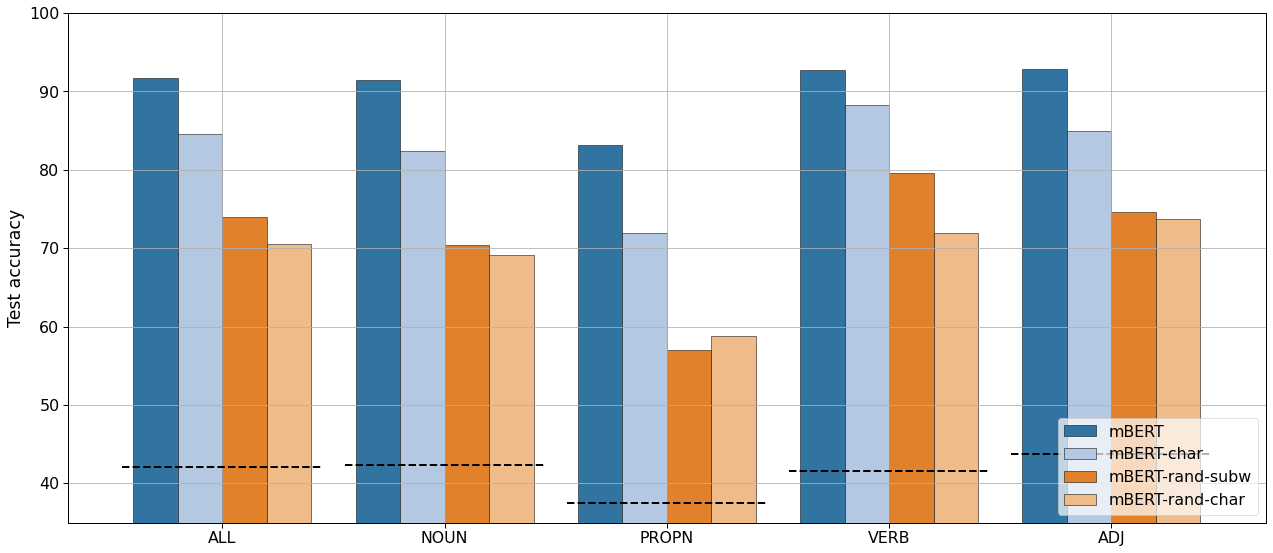

In [15]:
model_order = ['mBERT'] + model_perturbations # + baseline_models
with sns.plotting_context('paper', font_scale=1.8):
    fig, ax = plt.subplots(1, figsize=(18, 8), facecolor='w')
    sns.barplot(x=b.pos, y=b.test_acc, hue=b.model, hue_order=model_order, 
                palette='tab20',
                ci=None,
                edgecolor='black', linewidth=.5, ax=ax)
    ax.set_ylim(35, 100)
    ax.set_xlabel("")
    ax.set_ylabel("Test accuracy")
    ax.grid(True)
    ax.legend(title="", loc='lower right', framealpha=0.7, fancybox=True)
    
    for pi, p in enumerate(pos_order):
        yval = majority.loc[p]
        ax.plot((pi-0.45, pi+0.45), (yval, yval), linestyle='dashed', linewidth=2, color='black')
        
    plt.tight_layout()
    fig.savefig(f"{figure_dir}/bar_bert_modeling_perturbations_by_pos.pdf", dpi=600)

# Results


## Tokenization

mBERT-char

In [16]:
df = exps[
    ((exps['perturbation']=='mBERT-char') |
    ((exps['model']=='mBERT') & (exps['perturbation'].isnull()))
    ) &
    (exps['probing_location_better'])
].groupby(['family', 'language', 'task', 'perturbation'], dropna=False).test_acc.mean()
df = df.reset_index()
df['perturbation'] = df['perturbation'].fillna('mBERT')
df = df.rename(columns={'perturbation': 'model'})
means = df.groupby('model').mean()
means.loc['mBERT'] - means.loc['mBERT-char']

test_acc    7.206282
dtype: float64

In [17]:
d = df.groupby(['family', 'language', 'task', 'model']).test_acc.mean().unstack()
diff_col_name = 'mBERT - mBERT-char'
d[diff_col_name] = d['mBERT'] - d['mBERT-char']
d = d.reset_index()
d = d.merge(fertility, on=['language', 'task'])
d.corr().loc[diff_col_name].sort_values()

mBERT-char                  -0.812223
mBERT                       -0.354940
majority_baseline           -0.320644
sentence_word_len           -0.013655
target_fertility             0.016155
sentence_subword_len         0.048196
sentence_fertility           0.077217
first_entropy                0.159297
target_subw_entropy          0.159297
sentence_char_len            0.172708
sentence_char_per_subword    0.175577
target_char_per_subword      0.176016
target_char_len              0.181181
last_entropy                 0.420121
mBERT - mBERT-char           1.000000
Name: mBERT - mBERT-char, dtype: float64

In [18]:
d.corr()[diff_col_name].sort_values()

mBERT-char                  -0.812223
mBERT                       -0.354940
majority_baseline           -0.320644
sentence_word_len           -0.013655
target_fertility             0.016155
sentence_subword_len         0.048196
sentence_fertility           0.077217
first_entropy                0.159297
target_subw_entropy          0.159297
sentence_char_len            0.172708
sentence_char_per_subword    0.175577
target_char_per_subword      0.176016
target_char_len              0.181181
last_entropy                 0.420121
mBERT - mBERT-char           1.000000
Name: mBERT - mBERT-char, dtype: float64

In [19]:
d.groupby(['language']).mean().sort_values(diff_col_name)

,mBERT,mBERT-char,mBERT - mBERT-char,first_entropy,last_entropy,majority_baseline,sentence_char_len,sentence_char_per_subword,sentence_fertility,sentence_subword_len,sentence_word_len,target_char_len,target_char_per_subword,target_fertility,target_subw_entropy
language,,,,,,,,,,,,,,,
Hebrew,89.369310,87.585419,1.783892,5.210270,7.720722,42.857143,84.328887,2.011605,2.045988,42.057364,20.666230,5.049803,1.970029,2.764939,5.210270
Urdu,85.925000,83.887500,2.037500,7.258230,7.218278,57.125000,92.870000,2.056270,1.762899,45.386771,25.751979,5.355313,2.007779,2.923542,7.258230
Romanian,91.696965,89.567662,2.129303,8.778845,7.041988,42.963930,103.485233,2.522710,1.794445,40.804740,22.976610,7.801813,2.835670,2.997170,8.778845
Spanish,96.750000,94.385714,2.364286,9.438418,7.544925,43.500000,118.021310,3.425491,1.349437,34.474286,25.807798,8.576012,3.791639,2.495179,9.438418
Catalan,98.937500,96.546101,2.391399,9.033923,7.267638,46.525990,118.708903,3.061730,1.446146,38.779389,26.943788,8.305481,3.542712,2.557184,9.033923
Albanian,85.028571,82.385714,2.642857,8.849349,7.248655,46.214286,82.110910,2.480596,1.799899,32.770953,18.374647,7.719866,2.858888,2.939421,8.849349
Bulgarian,95.287720,91.943645,3.344075,7.384679,6.994835,46.754184,81.783887,2.479598,1.913988,32.638369,17.226783,8.167693,2.665630,3.280597,7.384679
Latvian,91.955721,88.072046,3.883675,7.762363,6.858597,41.979167,104.171765,2.321007,2.250113,44.474617,19.760012,8.241769,2.470253,3.483512,7.762363
Estonian,95.776726,91.876458,3.900268,8.405924,6.373816,39.587159,105.092264,2.615394,2.242909,39.909093,17.900749,8.959328,2.794038,3.308019,8.405924


In [20]:
df[df["language"] == "English"]

,family,language,task,model,test_acc
86,Germanic,English,number_noun,mBERT-char,97.85
87,Germanic,English,number_noun,mBERT,96.85
88,Germanic,English,tense_verb,mBERT-char,95.70
89,Germanic,English,tense_verb,mBERT,98.90
90,Germanic,English,verbform_verb,mBERT-char,77.70
91,Germanic,English,verbform_verb,mBERT,88.15


### mBERT-rand-char vs mBERT-rand-subw

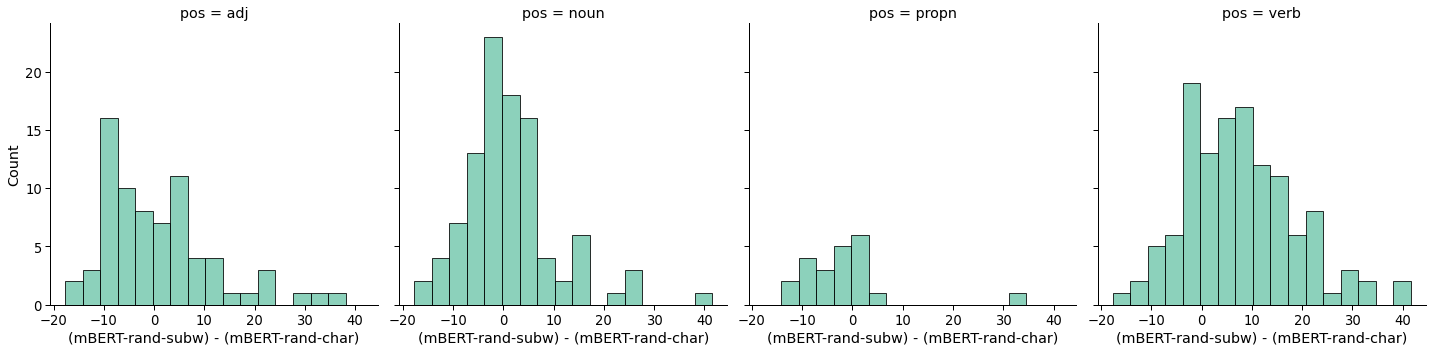

In [21]:
df = exps[
    (exps.model=='mBERT') &
    (exps.probing_location_better) &
    (exps.perturbation.isin(('mBERT-rand-char', 'mBERT-rand-subw')))
].groupby(['pos', 'language', 'task', 'perturbation'])['test_acc'].mean().unstack().reset_index()
diff_col_name = '(mBERT-rand-subw) - (mBERT-rand-char)'
df[diff_col_name] = df['mBERT-rand-subw'] - df['mBERT-rand-char']
sns.displot(data=df, x=diff_col_name, col='pos')

In [22]:
df.groupby('language')[diff_col_name].mean().sort_values()

language
English             -15.900000
Portuguese           -6.787500
Norwegian_Bokmal     -4.956645
German               -4.287336
Norwegian_Nynorsk    -4.286496
Swedish              -4.175000
Hindi                -3.908333
Arabic               -2.938308
Dutch                -2.257960
Slovak               -1.970803
Afrikaans            -1.350000
Hebrew               -1.102759
Albanian             -1.028571
French               -1.008673
Urdu                 -0.762500
Romanian             -0.728159
Polish               -0.362406
Danish               -0.357711
Serbian              -0.145274
Lithuanian            0.425000
Spanish               0.628571
Czech                 2.681910
Catalan               3.016770
Croatian              3.196371
Russian               3.216171
Ukrainian             3.681345
Hungarian             5.116667
Bulgarian             5.310357
Italian               5.381250
Armenian              6.183333
Slovenian             6.680401
Latin                 6.739285

In [23]:
df.sort_values(diff_col_name, ascending=True)[:30].groupby('task')[diff_col_name].mean().sort_values()

task
verbform_verb   -17.700000
case_adj        -13.875000
number_noun     -13.708333
tense_verb      -13.500000
gender_adj      -11.244652
voice_verb      -10.800000
gender_propn    -10.762376
definite_adj    -10.300000
gender_noun     -10.100000
number_adj       -9.525000
number_verb      -9.050000
Name: (mBERT-rand-subw) - (mBERT-rand-char), dtype: float64

In [24]:
df[df["language"] == "Hebrew"].sort_values(diff_col_name, ascending=True)

perturbation,pos,language,task,mBERT-rand-char,mBERT-rand-subw,(mBERT-rand-subw) - (mBERT-rand-char)
114,noun,Hebrew,gender_noun,93.950000,82.05000,-11.900000
246,verb,Hebrew,gender_verb,75.350000,68.50000,-6.850000
248,verb,Hebrew,number_verb,90.550000,91.75000,1.200000
115,noun,Hebrew,number_noun,79.550000,84.00000,4.450000
247,verb,Hebrew,hebbinyan_verb,34.679803,42.26601,7.586207


<AxesSubplot:ylabel='Density'>

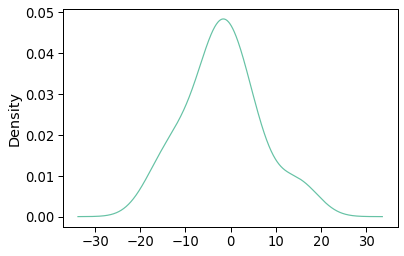

In [25]:
df[df["task"] == "number_noun"][diff_col_name].plot.kde(bw_method='silverman')

In [26]:
df[df["task"] == "number_noun"].sort_values(diff_col_name, ascending=True)

perturbation,pos,language,task,mBERT-rand-char,mBERT-rand-subw,(mBERT-rand-subw) - (mBERT-rand-char)
107,noun,French,number_noun,96.30,79.35,-16.95
100,noun,English,number_noun,97.25,80.75,-16.50
142,noun,Portuguese,number_noun,97.90,84.85,-13.05
99,noun,Dutch,number_noun,96.20,83.15,-13.05
160,noun,Spanish,number_noun,97.85,84.85,-13.00
110,noun,German,number_noun,74.65,64.95,-9.70
88,noun,Catalan,number_noun,97.80,89.15,-8.65
149,noun,Russian,number_noun,84.45,77.10,-7.35
123,noun,Italian,number_noun,84.90,77.75,-7.15
136,noun,Norwegian_Nynorsk,number_noun,81.75,77.15,-4.60


In [27]:
df[df["(mBERT-rand-subw) - (mBERT-rand-char)"] <= -10].sort_values(diff_col_name, ascending=True)

perturbation,pos,language,task,mBERT-rand-char,mBERT-rand-subw,(mBERT-rand-subw) - (mBERT-rand-char)
223,verb,English,verbform_verb,75.850000,58.150000,-17.700000
107,noun,French,number_noun,96.300000,79.350000,-16.950000
100,noun,English,number_noun,97.250000,80.750000,-16.500000
47,adj,Polish,case_adj,64.050000,47.900000,-16.150000
61,adj,Slovak,gender_adj,74.726368,59.502488,-15.223881
222,verb,English,tense_verb,94.150000,80.650000,-13.500000
189,propn,Polish,gender_propn,57.550000,44.450000,-13.100000
142,noun,Portuguese,number_noun,97.900000,84.850000,-13.050000
99,noun,Dutch,number_noun,96.200000,83.150000,-13.050000
160,noun,Spanish,number_noun,97.850000,84.850000,-13.000000


In [28]:
df.merge(fertility, on=['language', 'task']).corr()[diff_col_name].sort_values()

mBERT-rand-char                         -0.528768
last_entropy                            -0.369120
majority_baseline                       -0.289236
target_char_per_subword                 -0.196101
sentence_word_len                       -0.196088
first_entropy                           -0.194095
target_subw_entropy                     -0.194095
sentence_char_per_subword               -0.126599
sentence_char_len                        0.063987
sentence_subword_len                     0.126664
mBERT-rand-subw                          0.178067
target_char_len                          0.293622
target_fertility                         0.392599
sentence_fertility                       0.445860
(mBERT-rand-subw) - (mBERT-rand-char)    1.000000
Name: (mBERT-rand-subw) - (mBERT-rand-char), dtype: float64

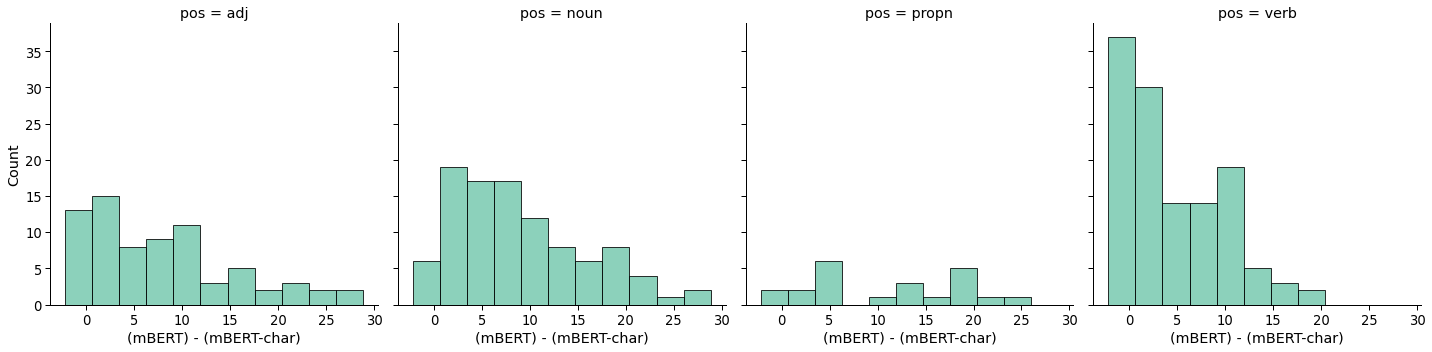

In [29]:
df = exps[
    (exps.model=='mBERT') &
    (exps.probing_location_better) &
    ((exps.perturbation=='mBERT-char') | (exps.perturbation.isnull()))
].copy()
df['perturbation'] = df['perturbation'].fillna('mBERT')
df = df.groupby(['pos', 'language', 'task', 'perturbation'])['test_acc'].mean().unstack().reset_index()
diff_col_name = '(mBERT) - (mBERT-char)'
df[diff_col_name] = df['mBERT'] - df['mBERT-char']
sns.displot(data=df, x=diff_col_name, col='pos')

In [30]:
df.groupby('language')[diff_col_name].mean().sort_values()

language
Hebrew                1.783892
Urdu                  2.037500
Romanian              2.129303
Spanish               2.364286
Catalan               2.391399
Albanian              2.642857
Bulgarian             3.344075
Latvian               3.883675
Estonian              3.900268
English               4.216667
Latin                 4.438678
Italian               4.525000
Afrikaans             4.650000
Danish                5.398607
Norwegian_Bokmal      5.404264
Portuguese            5.475000
Swedish               5.537500
Basque                5.641707
Norwegian_Nynorsk     5.984790
Persian               6.100000
Hindi                 6.258333
French                6.788868
Arabic                6.809784
Turkish               7.218205
Greek                 8.136965
Czech                 8.339045
Polish                8.484875
Lithuanian            8.593873
Slovak                8.675026
Croatian              8.827590
Armenian              9.350000
Hungarian             9.750000

In [31]:
df.merge(fertility, on=['language', 'task']).corr()[diff_col_name].sort_values()

mBERT-char                  -0.812223
mBERT                       -0.354940
majority_baseline           -0.320644
sentence_word_len           -0.013655
target_fertility             0.016155
sentence_subword_len         0.048196
sentence_fertility           0.077217
first_entropy                0.159297
target_subw_entropy          0.159297
sentence_char_len            0.172708
sentence_char_per_subword    0.175577
target_char_per_subword      0.176016
target_char_len              0.181181
last_entropy                 0.420121
(mBERT) - (mBERT-char)       1.000000
Name: (mBERT) - (mBERT-char), dtype: float64